# Classify Bank Complaints

## Business Problem 


It is clear that most of the businessess are client oriented and their success depends on customers' experiences. Customer complaints categorization can be useful to automatically categorize the reason of client's unsatisfaction and help to quickly respond to them when they (and your company) need it most. This project aims to classify the complains of bank customers.



## Data

The data for this project was obtained from **Consumer Financial Protection Bureau**. It is a collection of complaints about consumer financial products and services that were sent to companies for response. The data consists of **more than 2 million observations and 17 features.**


## Import Packages

First, I will start by importing all of the required packages and classes.

In [1]:
!pip install keras
!pip install tensorflow

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras import models
from keras import layers
from keras import optimizers
from keras.models import load_model

from keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

## Upload Data

Upload the `bank_complaints.csv` file.

In [3]:
# Import data
df = pd.read_csv('complaints.csv')

# Inspect data
print(df.info())
df.head()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2367005 entries, 0 to 2367004
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 325.

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,PA,18640,NaN,Consent not provided,Web,2019-06-13,Closed with explanation,Yes,NaN,3274605
1,2019-11-01,Vehicle loan or lease,Loan,Struggling to pay your loan,Denied request to lower payments,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,ALLY FINANCIAL INC.,NJ,8854,NaN,Consent provided,Web,2019-11-01,Closed with explanation,Yes,NaN,3425257
2,2019-04-01,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19067,NaN,Consent not provided,Web,2019-04-01,Closed with explanation,Yes,NaN,3198225
3,2020-03-03,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Personal information incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TN,38141,NaN,Consent not provided,Web,2020-03-03,Closed with explanation,Yes,NaN,3552062
4,2020-01-28,"Credit reporting, credit repair services, or o...",Credit reporting,Credit monitoring or identity theft protection...,Billing dispute for services,Naviant had made me a promise that if I took o...,NaN,"Navient Solutions, LLC.",CA,92625,NaN,Consent provided,Web,2020-01-28,Closed with explanation,Yes,NaN,3511521


## Data Cleaning

* It is clear that the `Consumer complaint narrative` feature has NaN values. I will look into that.

In [4]:
df['Consumer complaint narrative'].isna().sum()

1539379

* There are 1 539 379 missing values out of 2 367 005. Since the data has sufficient amount of observations, I will drop the NaN valued observations.

As mentioned earlier, I will categorize banking complaints into various predefined categories. Now, I will preview what these categories are and what percent of the complaints each accounts for. 

In [5]:
df['Product'].value_counts(normalize=True)

Credit reporting, credit repair services, or other personal consumer reports    0.374353
Debt collection                                                                 0.166460
Mortgage                                                                        0.144527
Credit reporting                                                                0.059329
Credit card or prepaid card                                                     0.053987
Checking or savings account                                                     0.044861
Credit card                                                                     0.037681
Bank account or service                                                         0.036420
Student loan                                                                    0.027032
Money transfer, virtual currency, or money service                              0.014692
Consumer Loan                                                                   0.013350
Vehicle loan or lease

* Since some categories are duplicated I will combine them.

In [6]:
df['Product'] = df['Product'].apply(lambda x: 'Credit Reporting' if 'reporting' in x else x)
df['Product'].value_counts(normalize=True)

Credit Reporting                                      0.433681
Debt collection                                       0.166460
Mortgage                                              0.144527
Credit card or prepaid card                           0.053987
Checking or savings account                           0.044861
Credit card                                           0.037681
Bank account or service                               0.036420
Student loan                                          0.027032
Money transfer, virtual currency, or money service    0.014692
Consumer Loan                                         0.013350
Vehicle loan or lease                                 0.012319
Payday loan, title loan, or personal loan             0.008319
Payday loan                                           0.002342
Money transfers                                       0.002262
Prepaid card                                          0.001613
Other financial service                               0

In [7]:
df['Product'] = df['Product'].apply(lambda x: 'Money transfer, virtual currency, or money service' 
                                    if ('transfers' in x or 'Virtual' in x) else x)
df['Product'].value_counts(normalize=True)

Credit Reporting                                      0.433681
Debt collection                                       0.166460
Mortgage                                              0.144527
Credit card or prepaid card                           0.053987
Checking or savings account                           0.044861
Credit card                                           0.037681
Bank account or service                               0.036420
Student loan                                          0.027032
Money transfer, virtual currency, or money service    0.016962
Consumer Loan                                         0.013350
Vehicle loan or lease                                 0.012319
Payday loan, title loan, or personal loan             0.008319
Payday loan                                           0.002342
Prepaid card                                          0.001613
Other financial service                               0.000447
Name: Product, dtype: float64

In [8]:
df['Product'] = df['Product'].apply(lambda x: 'Credit card or prepaid card' 
                                    if ('Prepaid' in x or 'card' in x) else x)
df['Product'].value_counts(normalize=True)

Credit Reporting                                      0.433681
Debt collection                                       0.166460
Mortgage                                              0.144527
Credit card or prepaid card                           0.093281
Checking or savings account                           0.044861
Bank account or service                               0.036420
Student loan                                          0.027032
Money transfer, virtual currency, or money service    0.016962
Consumer Loan                                         0.013350
Vehicle loan or lease                                 0.012319
Payday loan, title loan, or personal loan             0.008319
Payday loan                                           0.002342
Other financial service                               0.000447
Name: Product, dtype: float64

In [9]:
df['Product'] = df['Product'].apply(lambda x: 'Payday loan, title loan, or personal loan' if 'Payday' in x else x)
df['Product'].value_counts(normalize=True)

Credit Reporting                                      0.433681
Debt collection                                       0.166460
Mortgage                                              0.144527
Credit card or prepaid card                           0.093281
Checking or savings account                           0.044861
Bank account or service                               0.036420
Student loan                                          0.027032
Money transfer, virtual currency, or money service    0.016962
Consumer Loan                                         0.013350
Vehicle loan or lease                                 0.012319
Payday loan, title loan, or personal loan             0.010661
Other financial service                               0.000447
Name: Product, dtype: float64

* Now I have only 12 categories of products.

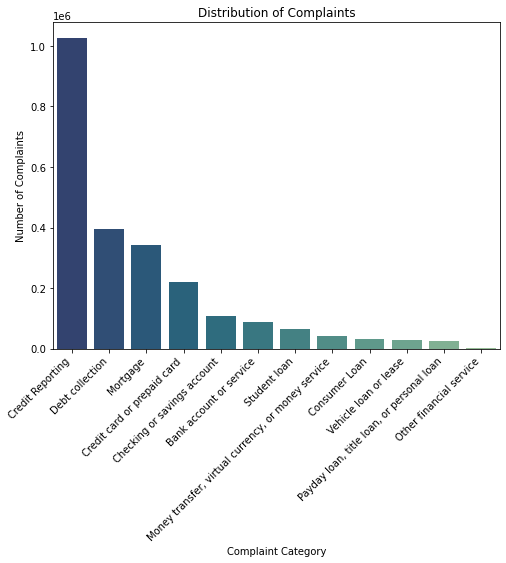

In [10]:
fig = plt.figure(figsize=(8,6))

plt.xticks(rotation=45, horizontalalignment='right')

ax = sns.countplot(x="Product", data=df,
                   order = df['Product'].value_counts().index, 
                   palette = 'crest_r')

plt.xlabel('Complaint Category')
plt.ylabel('Number of Complaints')
plt.title("Distribution of Complaints")
plt.show()

* Most of the complaints are related to Credit Reporting Category

# Data Exploration

## Sub Product

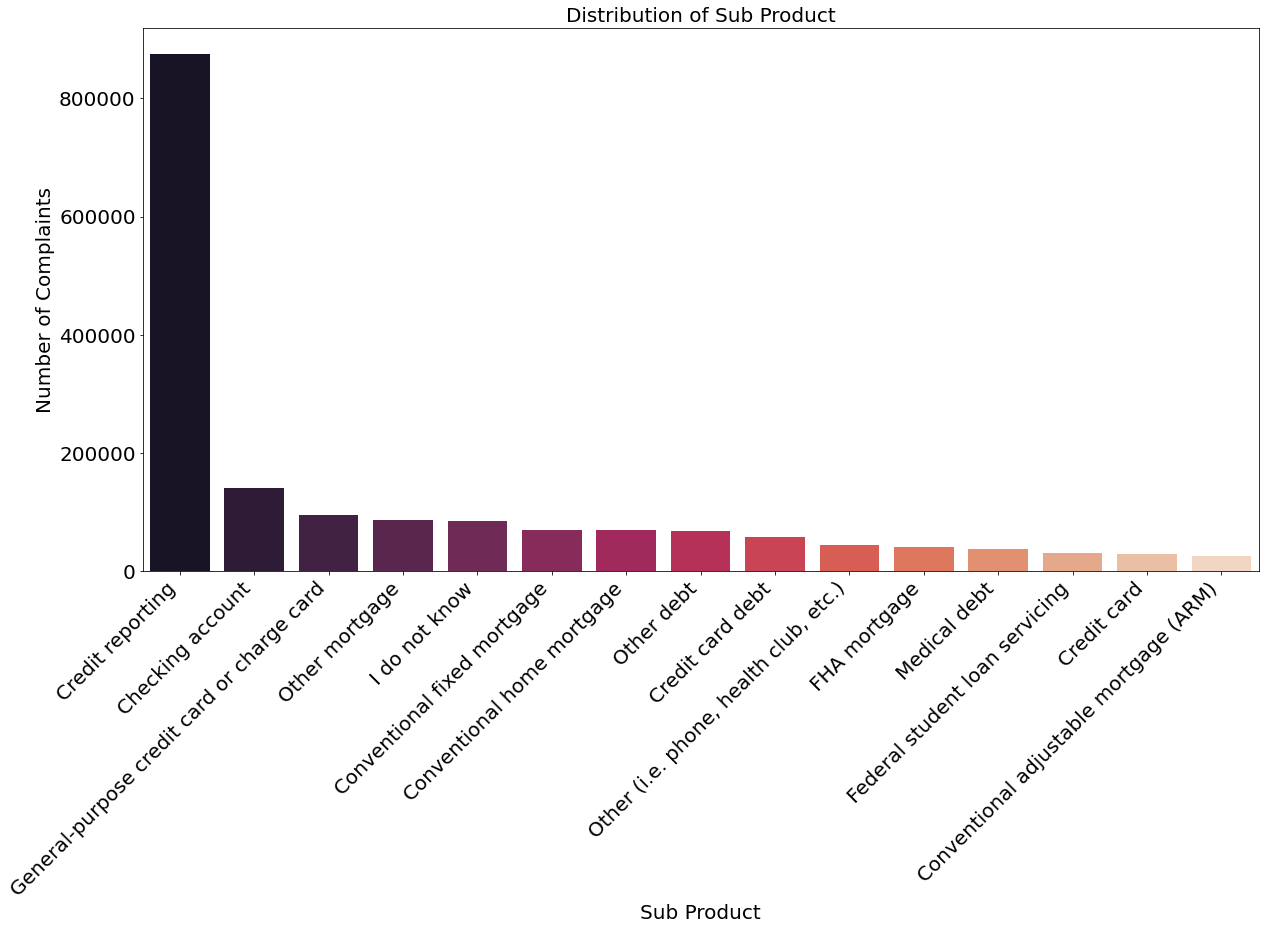

In [11]:
plt.figure(figsize =(20,10))
plt.xticks(rotation=45, horizontalalignment='right', fontsize = 20)
plt.yticks(fontsize = 20)



ax = sns.countplot(x="Sub-product", data=df,
                   order = df['Sub-product'].value_counts().head(15).index, 
                   palette = 'rocket')


plt.xlabel('Sub Product', fontsize = 20)
plt.ylabel('Number of Complaints', fontsize = 20)
plt.title('Distribution of Sub Product', fontsize = 20)
plt.show()

## Issue

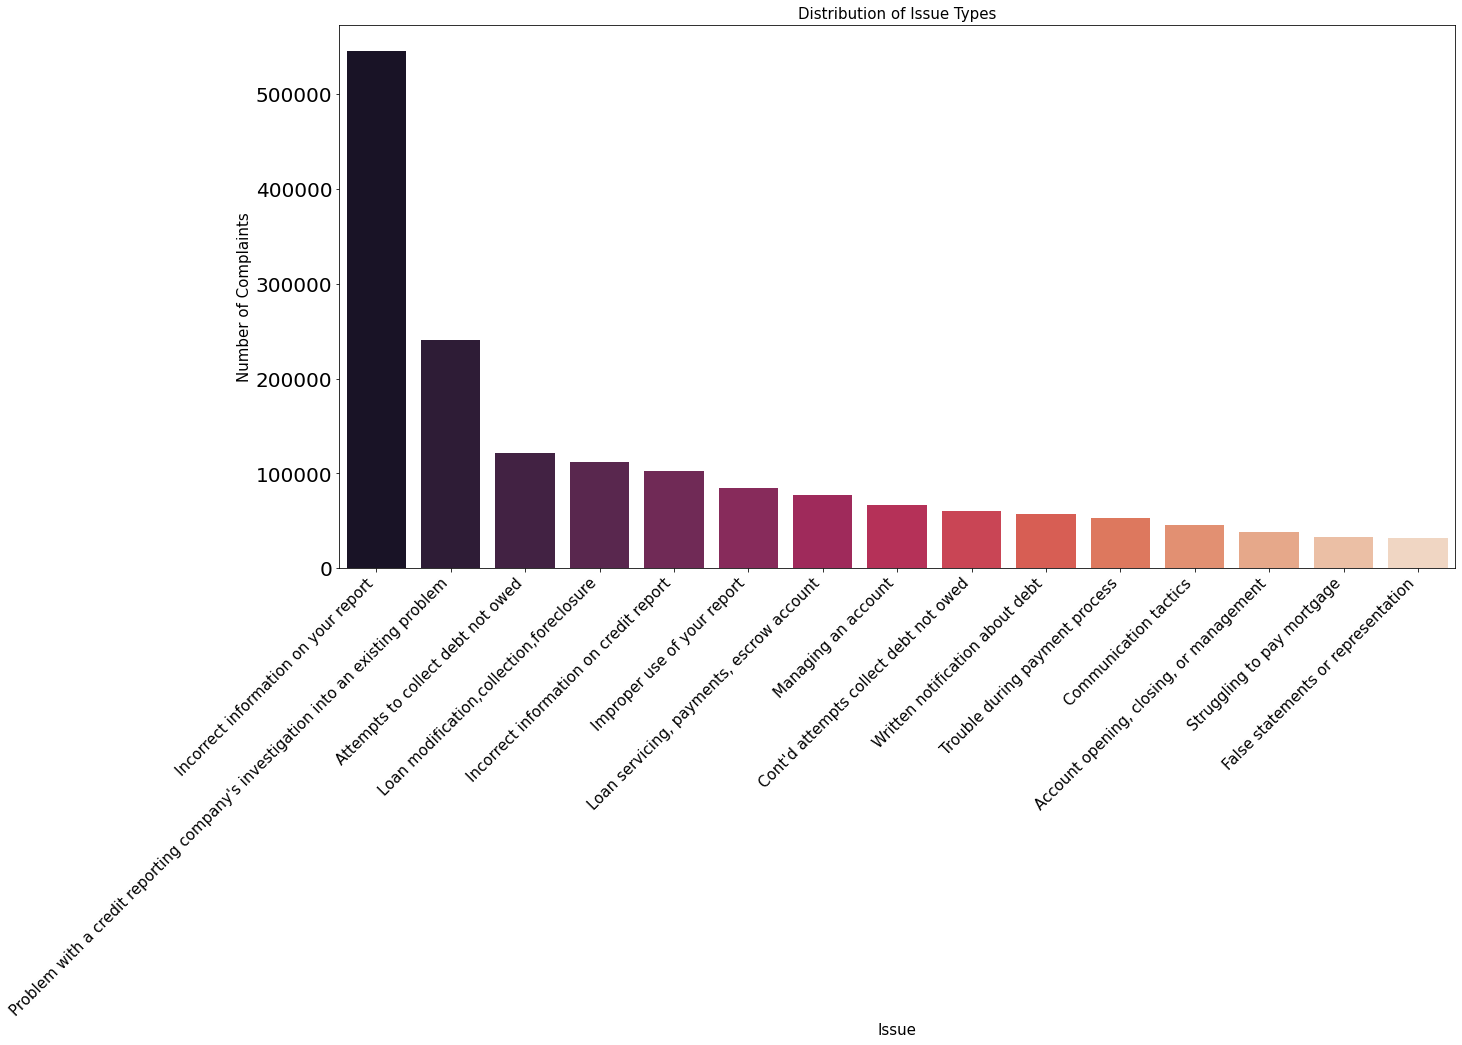

In [12]:
plt.figure(figsize =(20,10))
plt.xticks(rotation=45, horizontalalignment='right', fontsize = 15)
plt.yticks(fontsize = 20)


ax = sns.countplot(x="Issue", data=df,
                   order = df['Issue'].value_counts().head(15).index, 
                   palette = 'rocket')


plt.xlabel('Issue', fontsize = 15)
plt.ylabel('Number of Complaints', fontsize = 15)
plt.title('Distribution of Issue Types', fontsize = 15)
plt.show()

## Company Response

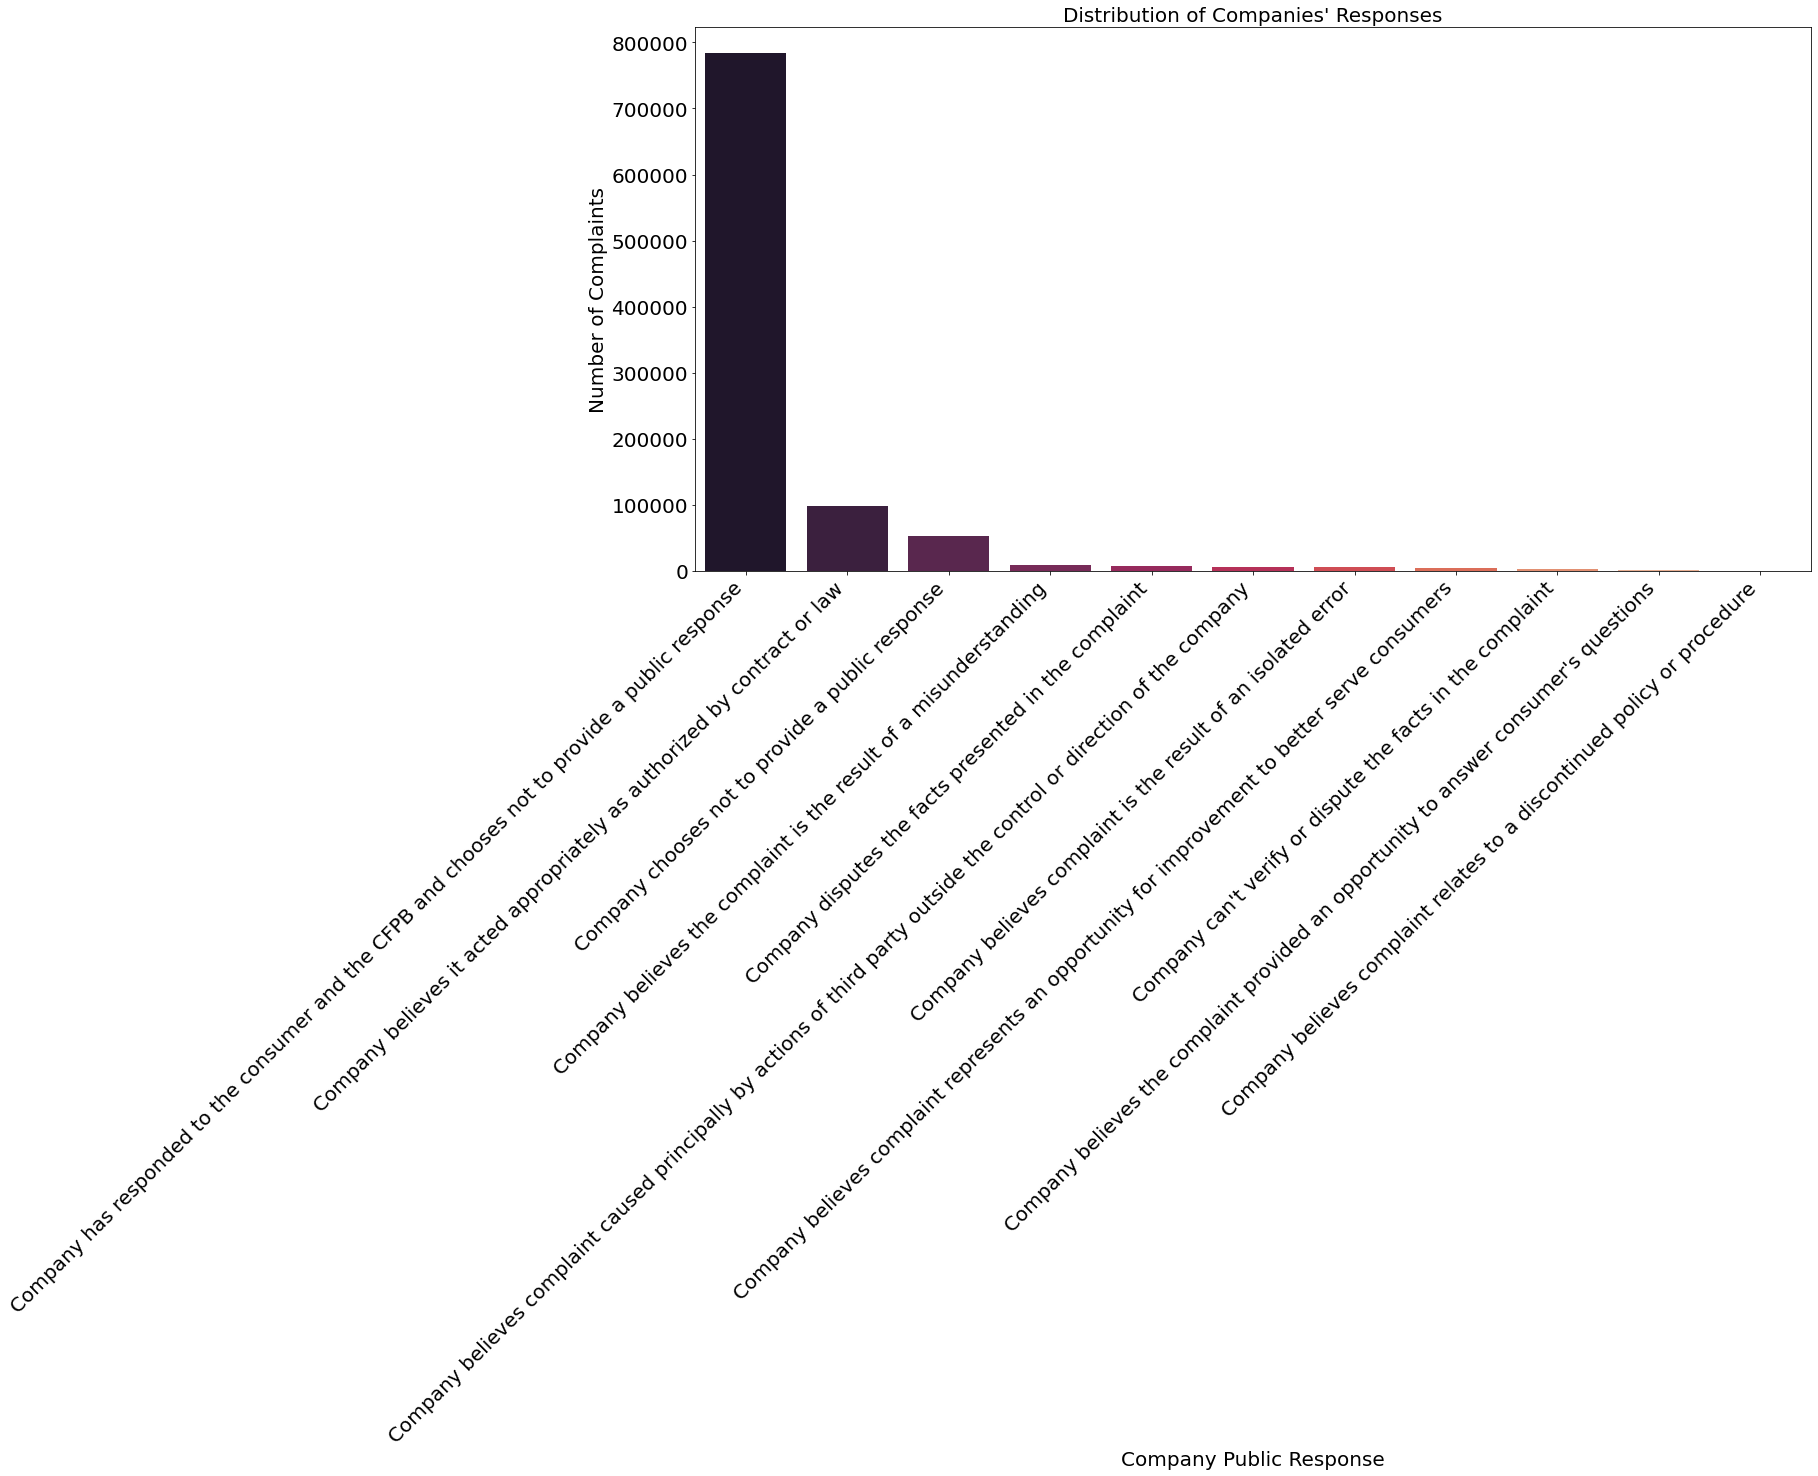

In [13]:
plt.figure(figsize =(20,10))
plt.xticks(rotation=45, horizontalalignment='right', fontsize = 20)
plt.yticks(fontsize = 20)

ax = sns.countplot(x="Company public response", data=df,
                   order = df['Company public response'].value_counts().head(15).index, 
                   palette = 'rocket')


plt.xlabel('Company Public Response', fontsize = 20)
plt.ylabel('Number of Complaints', fontsize = 20)
plt.title('Distribution of Companies\' Responses', fontsize = 20)
plt.show()

## Company

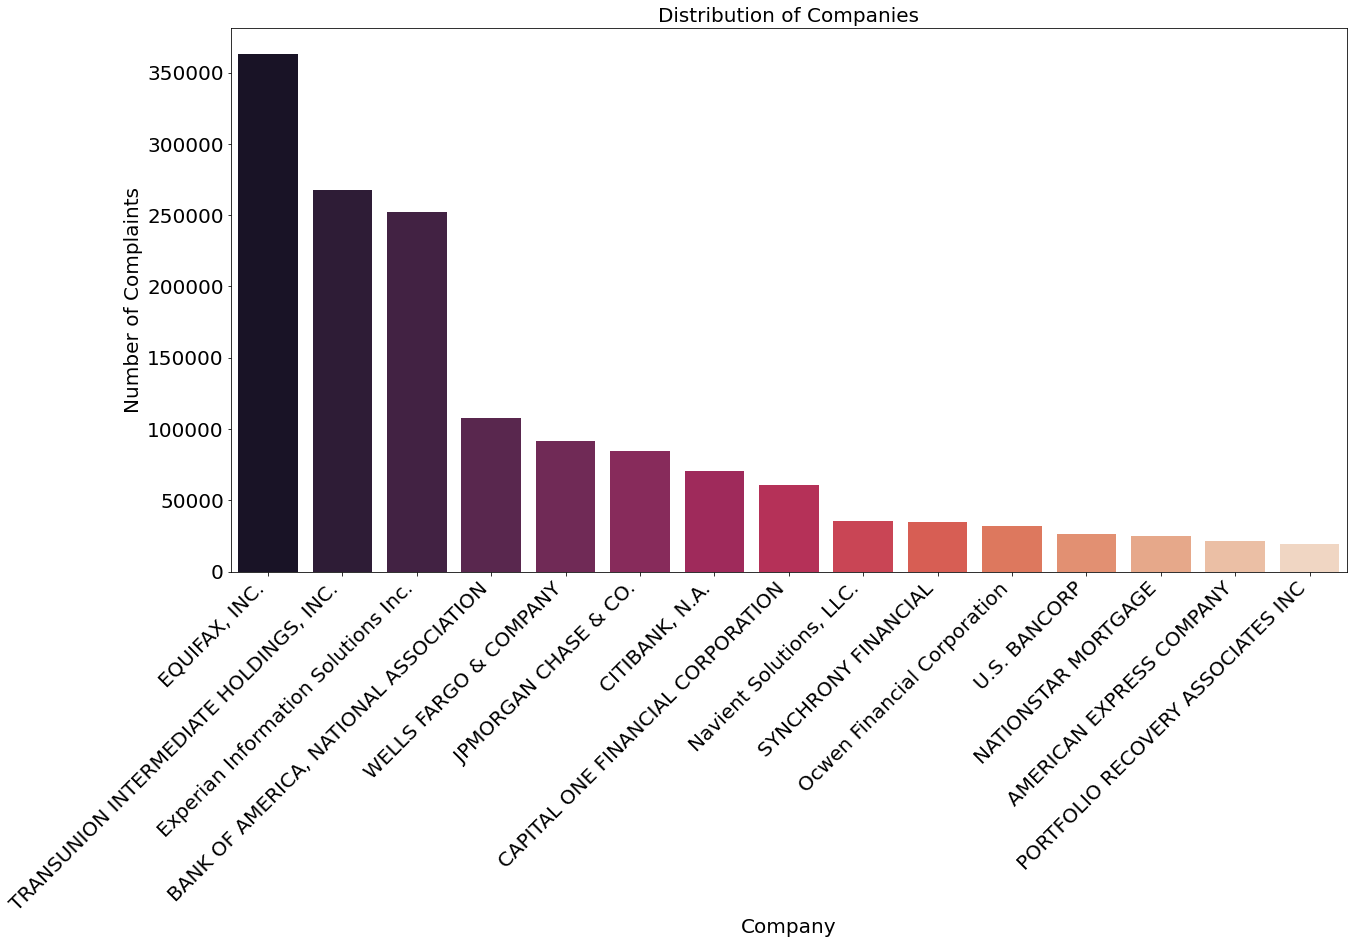

In [14]:
plt.figure(figsize =(20,10))
plt.xticks(rotation=45, horizontalalignment='right', fontsize = 20)
plt.yticks(fontsize = 20)

ax = sns.countplot(x="Company", data=df,
                   order = df['Company'].value_counts().head(15).index, 
                   palette = 'rocket')


plt.xlabel('Company', fontsize = 20)
plt.ylabel('Number of Complaints', fontsize = 20)
plt.title('Distribution of Companies', fontsize = 20)
plt.show()

# EDA Results:

* Most of the complaints are **related to credit reporting**
* The most common issue is that **company has incorrect information**
* Vast amount of the complaints were **responded by companies to customer and CFBP**
* Majority of the complaints are directed to **Equifax and Transunion**

For the purpose of the project I will keep only two features from this dataset: `Product` and `Consumer Complaint Narrative`. 

In [15]:
df = df[['Product', 'Consumer complaint narrative']]
df.head()

,Product,Consumer complaint narrative
0,Credit Reporting,NaN
1,Vehicle loan or lease,I contacted Ally on Friday XX/XX/XXXX after fa...
2,Credit Reporting,NaN
3,Credit Reporting,NaN
4,Credit Reporting,Naviant had made me a promise that if I took o...


In [16]:
df.dropna(inplace = True)
df.head()

,Product,Consumer complaint narrative
1,Vehicle loan or lease,I contacted Ally on Friday XX/XX/XXXX after fa...
4,Credit Reporting,Naviant had made me a promise that if I took o...
6,Credit Reporting,Hello This complaint is against the three cred...
7,Credit Reporting,I am a victim of Identity Theft & currently ha...
9,Credit Reporting,Two accounts are still on my credit history af...


In [17]:
df.reset_index(inplace = True)

# Preprocessing

Before starting modeling process, I will perform several preprocessing steps:  

* Sampling in order to reduce training time (investigate model accuracy vs data size later on)
* Train - test split
* One-hot encoding complaint text
* Transforming category labels

## Preprocess -1
### Generating Random Sample

Since I have quite a bit of data and training neural networks takes a substantial amount of time and resources, I will downsample in order to test initial pipeline.

* I will generate a random sample of 10,000 observations using seed 123 for consistency of results.
* Then, split this sample into X and y

In [18]:
df_sample = df.sample(10000, random_state=123)

y = df_sample['Product']
X = df_sample['Consumer complaint narrative']

### Train - Test Split

* I will split the data into training and test sets
* And assign 1500 obervations to the test set (use 42 as the seed)
* Then, I will divide the training data into training and validation sets for the purpose of hyperparameter tuning.


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1500, random_state=42)

In [20]:
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=1000, random_state=42)

## Preprocess - 2

First, I will create word vector counts of complaints text. Next, I will change the category labels to integers. 

### One-hot Encoding of the Complaints

My first step is to transform textual data into a numerical representation. I will use the `Tokenizer()` class from the `preprocessing.text` sub-module of the Keras package. This will transform text complaints into word vectors. In the below code, I'll only keep the 2,000 most common words and use one-hot encoding. 

In [21]:
# Keep the 3,000 most common words and use one-hot encoding to reformat the complaints into a matrix of vectors
tokenizer = Tokenizer(num_words=3000)
tokenizer.fit_on_texts(X_train_final)

# Transform the training, validate, and test sets
X_train_tokens = tokenizer.texts_to_matrix(X_train_final, mode='binary')
X_val_tokens = tokenizer.texts_to_matrix(X_val, mode='binary')
X_test_tokens = tokenizer.texts_to_matrix(X_test, mode='binary')

In [22]:
print('Dimensions of encoded x_train set:', np.shape(X_train_tokens))
print('Dimensions of encoded x_validation set:', np.shape(X_val_tokens))
print('Dimensions of encoded x_test set:', np.shape(X_test_tokens))

Dimensions of encoded x_train set: (7500, 3000)
Dimensions of encoded x_validation set: (1000, 3000)
Dimensions of encoded x_test set: (1500, 3000)


In [23]:
# To decode vectors
word_index = tokenizer.word_index 

In [24]:
# Tokens are the number of unique words across the corpus
print('Found %s unique tokens.' % len(word_index)) 

Found 17024 unique tokens.


### Decoding Word Vectors 

The `word_index` variable, defined above, stores the mapping from the label number to the actual word. I will reverse current dictionarty `word_index` which maps words from corpus to integers. In decoding `one_hot_results`, I will create a dictionary of these integers to the original words. Below, I'll take the `word_index` dictionary object and change the orientation so that the values are keys and the keys values.

In [25]:
reverse_index = dict([(value, key) for (key, value) in word_index.items()])

In [26]:
# Create sequences for train, validation and test sets to retrieve original words
X_train_seq = tokenizer.texts_to_sequences(X_train_final)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [27]:
# Reset index of train set
x_train_idx = X_train_final.reset_index(drop = True)

# choose the observation for preview (0 index chosen)
comment_idx_to_preview = 0
print('Original complaint text:')
print(x_train_idx[comment_idx_to_preview])
print('\n\n')
 
decoded_review = ' '.join([reverse_index.get(i) for i in X_train_seq[comment_idx_to_preview]])
print('Decoded review from Tokenizer:')
print(decoded_review)

Original complaint text:
XXXX XXXX  will not remove the dispute Im requesting.. Ive already contacted them and explain that the auto loan was fraudulent put in my name by a family voluntarily turn it in ... Im so hurt because now my credit is destroyed from a auto loan I wasnt responsible for myself



Decoded review from Tokenizer:
xxxx xxxx will not remove the dispute im requesting ive already contacted them and explain that the auto loan was fraudulent put in my name by a family voluntarily turn it in im so hurt because now my credit is from a auto loan i wasnt responsible for myself


### Convert the Products to Numerical Categories

Converting descriptive categories into integers.

In [28]:
# Transform the product labels to numerical values
lb = LabelBinarizer()
lb.fit(y_train_final)

y_train_lb = to_categorical(lb.transform(y_train_final))[:, :, 1]
y_val_lb = to_categorical(lb.transform(y_val))[:, :, 1]
y_test_lb = to_categorical(lb.transform(y_test))[:, :, 1]

In [29]:
print('Original class labels:')
print(list(lb.classes_))
print('\n')

Original class labels:
['Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Credit Reporting', 'Credit card or prepaid card', 'Debt collection', 'Money transfer, virtual currency, or money service', 'Mortgage', 'Other financial service', 'Payday loan, title loan, or personal loan', 'Student loan', 'Vehicle loan or lease']




In [30]:
# To retrieve the original descriptive labels post production
y_train_labels = list(lb.inverse_transform(y_train_lb)) 
y_test_labels = list(lb.inverse_transform(y_train_lb)) 

## Building the network

I will build a fully connected (Dense) layer network with relu activation in Keras. There are two hidden layers with 50 units in the first layer and 25 in the second, both with a `'relu'` activation function. Because I am dealing with a multiclass problem (classifying the complaints into 12 categories), I use a `'softmax'` classifier in order to output 12 class probabilities per case.  

In [31]:
random.seed(123)
# Initialize a sequential model
model = models.Sequential()

# Two layers with relu activation
model.add(layers.Dense(50, activation='relu', input_shape=(3000,)))
model.add(layers.Dense(25, activation='relu'))

# One layer with softmax activation 
model.add(layers.Dense(12, activation='softmax'))

## Compiling the model

Now, I will compile the model. I will use `'categorical_crossentropy'` as the loss function and stochastic gradient descent, `'SGD'` as the optimizer. And include the accuracy as a metric.

In [32]:
# Compile the model
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['acc'])

## Training the model

* As a baseline, I will train the model for 150 epochs in mini-batches of 256 samples
* And include the validation_data argument to ensure I keep track of the validation loss


In [33]:
# Train the model
baseline_model_val = model.fit(X_train_tokens,
                               y_train_lb,
                               epochs=150,
                               batch_size=256,
                               validation_data=(X_val_tokens, y_val_lb))

Epoch 1/150
30/30 [==============================] - 0s 8ms/step - loss: 2.4890 - acc: 0.1211 - val_loss: 2.4326 - val_acc: 0.2460
Epoch 2/150
30/30 [==============================] - 0s 3ms/step - loss: 2.3967 - acc: 0.3243 - val_loss: 2.3547 - val_acc: 0.3890
Epoch 3/150
30/30 [==============================] - 0s 3ms/step - loss: 2.3202 - acc: 0.4095 - val_loss: 2.2753 - val_acc: 0.4220
Epoch 4/150
30/30 [==============================] - 0s 4ms/step - loss: 2.2312 - acc: 0.4412 - val_loss: 2.1747 - val_acc: 0.4540
Epoch 5/150
30/30 [==============================] - 0s 4ms/step - loss: 2.1193 - acc: 0.4373 - val_loss: 2.0559 - val_acc: 0.4440
Epoch 6/150
30/30 [==============================] - 0s 4ms/step - loss: 2.0011 - acc: 0.4336 - val_loss: 1.9454 - val_acc: 0.4420
Epoch 7/150
30/30 [==============================] - 0s 4ms/step - loss: 1.9029 - acc: 0.4333 - val_loss: 1.8646 - val_acc: 0.4430
Epoch 8/150
30/30 [==============================] - 0s 4ms/step - loss: 1.8309 - a

30/30 [==============================] - 0s 4ms/step - loss: 0.7582 - acc: 0.7720 - val_loss: 0.9177 - val_acc: 0.7200
Epoch 64/150
30/30 [==============================] - 0s 3ms/step - loss: 0.7518 - acc: 0.7745 - val_loss: 0.9125 - val_acc: 0.7220
Epoch 65/150
30/30 [==============================] - 0s 4ms/step - loss: 0.7454 - acc: 0.7773 - val_loss: 0.9130 - val_acc: 0.7230
Epoch 66/150
30/30 [==============================] - 0s 3ms/step - loss: 0.7386 - acc: 0.7795 - val_loss: 0.9078 - val_acc: 0.7250
Epoch 67/150
30/30 [==============================] - 0s 4ms/step - loss: 0.7318 - acc: 0.7804 - val_loss: 0.9055 - val_acc: 0.7260
Epoch 68/150
30/30 [==============================] - 0s 4ms/step - loss: 0.7255 - acc: 0.7852 - val_loss: 0.9025 - val_acc: 0.7260
Epoch 69/150
30/30 [==============================] - 0s 3ms/step - loss: 0.7193 - acc: 0.7849 - val_loss: 0.8993 - val_acc: 0.7290
Epoch 70/150
30/30 [==============================] - 0s 4ms/step - loss: 0.7130 - acc: 0

Epoch 125/150
30/30 [==============================] - 0s 4ms/step - loss: 0.4828 - acc: 0.8569 - val_loss: 0.8622 - val_acc: 0.7410
Epoch 126/150
30/30 [==============================] - 0s 4ms/step - loss: 0.4806 - acc: 0.8588 - val_loss: 0.8664 - val_acc: 0.7440
Epoch 127/150
30/30 [==============================] - 0s 4ms/step - loss: 0.4778 - acc: 0.8576 - val_loss: 0.8612 - val_acc: 0.7440
Epoch 128/150
30/30 [==============================] - 0s 4ms/step - loss: 0.4739 - acc: 0.8609 - val_loss: 0.8622 - val_acc: 0.7420
Epoch 129/150
30/30 [==============================] - 0s 3ms/step - loss: 0.4711 - acc: 0.8603 - val_loss: 0.8638 - val_acc: 0.7410
Epoch 130/150
30/30 [==============================] - 0s 4ms/step - loss: 0.4682 - acc: 0.8631 - val_loss: 0.8677 - val_acc: 0.7380
Epoch 131/150
30/30 [==============================] - 0s 3ms/step - loss: 0.4655 - acc: 0.8633 - val_loss: 0.8648 - val_acc: 0.7460
Epoch 132/150
30/30 [==============================] - 0s 4ms/step - 

## Model Performance

The attribute .history (stored as a dictionary) contains four entries: one per metric that was being monitored during training and validation.

In [34]:
# Access the history attribute and store the dictionary
baseline_model_val_dict = baseline_model_val.history

### Evaluate on Training Set

In [35]:
results_train = model.evaluate(X_train_tokens, y_train_lb)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

235/235 [==============================] - 0s 784us/step - loss: 0.4126 - acc: 0.8805
----------
Training Loss: 0.413 
Training Accuracy: 0.881


### Evaluate on Test Set

In [36]:
results_test = model.evaluate(X_test_tokens, y_test_lb)
print('----------')
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')


47/47 [==============================] - 0s 742us/step - loss: 0.8055 - acc: 0.7500
----------
Test Loss: 0.806 
Test Accuracy: 0.75


* There is an overfitting

## Plot the results

I will use the data stored in the `baseline_model_val_dict` above to plot the loss vs epochs and the accuracy vs epochs. 

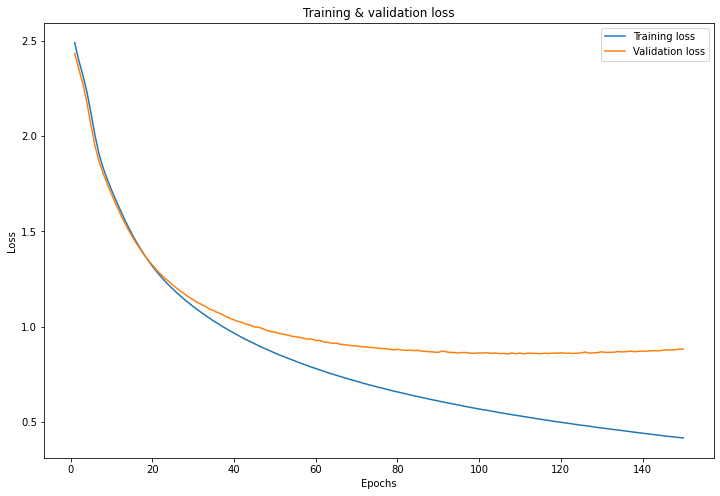

In [37]:
# Plot the loss vs the number of epoch

fig, ax = plt.subplots(figsize=(12, 8))

loss_values = baseline_model_val_dict['loss']
val_loss_values = baseline_model_val_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
ax.plot(epochs, loss_values, label='Training loss')
ax.plot(epochs, val_loss_values, label='Validation loss')

ax.set_title('Training & validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

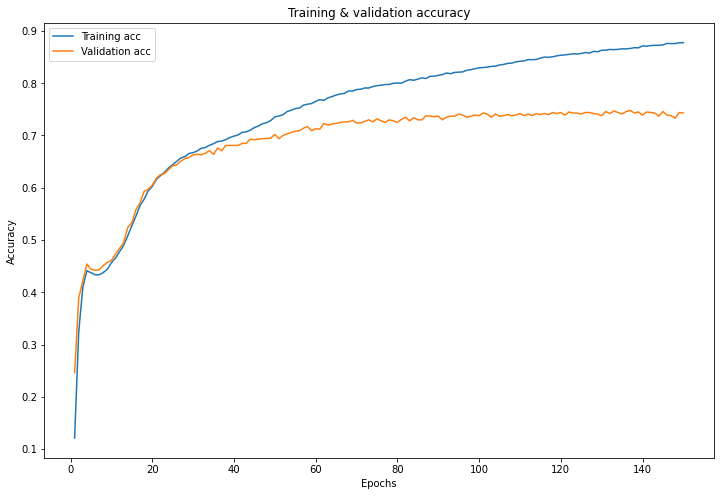

In [38]:
# Plot the training accuracy vs the number of epochs

fig, ax = plt.subplots(figsize=(12, 8))

acc_values = baseline_model_val_dict['acc'] 
val_acc_values = baseline_model_val_dict['val_acc']

ax.plot(epochs, acc_values, label='Training acc')
ax.plot(epochs, val_acc_values, label='Validation acc')
ax.set_title('Training & validation accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend();

The graphs show that although the training accuracy keeps increasing when going through more epochs, and the training loss keeps decreasing, the validation accuracy and loss don't do the same. After a certain point, validation accuracy keeps swinging, which means that model overfitting the training data when training for many epochs past a certain dropoff point. I will specify an early stopping point in order to solve the problem.

## Model 2: Early Stopping

In [39]:
random.seed(123)
model_2 = models.Sequential()
model_2.add(layers.Dense(50, activation='relu', input_shape=(3000,)))
model_2.add(layers.Dense(25, activation='relu'))
model_2.add(layers.Dense(12, activation='softmax'))

model_2.compile(optimizer='SGD', 
                loss='categorical_crossentropy', 
                metrics=['acc'])

In [40]:
# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [41]:
model_2_val = model_2.fit(X_train_tokens, 
                          y_train_lb, 
                          epochs=150, 
                          callbacks=early_stopping, 
                          batch_size=256, 
                          validation_data=(X_val_tokens, y_val_lb))

Epoch 1/150
30/30 [==============================] - 1s 12ms/step - loss: 2.3124 - acc: 0.3779 - val_loss: 2.1635 - val_acc: 0.4400
Epoch 2/150
30/30 [==============================] - 0s 4ms/step - loss: 2.0526 - acc: 0.4315 - val_loss: 1.9666 - val_acc: 0.4400
Epoch 3/150
30/30 [==============================] - 0s 4ms/step - loss: 1.9023 - acc: 0.4315 - val_loss: 1.8591 - val_acc: 0.4400
Epoch 4/150
30/30 [==============================] - 0s 4ms/step - loss: 1.8077 - acc: 0.4333 - val_loss: 1.7724 - val_acc: 0.4470
Epoch 5/150
30/30 [==============================] - 0s 4ms/step - loss: 1.7290 - acc: 0.4477 - val_loss: 1.6949 - val_acc: 0.4640
Epoch 6/150
30/30 [==============================] - 0s 5ms/step - loss: 1.6631 - acc: 0.4631 - val_loss: 1.6336 - val_acc: 0.4720
Epoch 7/150
30/30 [==============================] - 0s 4ms/step - loss: 1.6097 - acc: 0.4763 - val_loss: 1.5827 - val_acc: 0.4920
Epoch 8/150
30/30 [==============================] - 0s 4ms/step - loss: 1.5641 - 

30/30 [==============================] - 0s 4ms/step - loss: 0.7488 - acc: 0.7703 - val_loss: 0.9024 - val_acc: 0.7190
Epoch 64/150
30/30 [==============================] - 0s 4ms/step - loss: 0.7423 - acc: 0.7715 - val_loss: 0.8997 - val_acc: 0.7170
Epoch 65/150
30/30 [==============================] - 0s 4ms/step - loss: 0.7366 - acc: 0.7740 - val_loss: 0.8979 - val_acc: 0.7220
Epoch 66/150
30/30 [==============================] - 0s 4ms/step - loss: 0.7302 - acc: 0.7759 - val_loss: 0.8962 - val_acc: 0.7180
Epoch 67/150
30/30 [==============================] - 0s 4ms/step - loss: 0.7250 - acc: 0.7765 - val_loss: 0.8963 - val_acc: 0.7200
Epoch 68/150
30/30 [==============================] - 0s 4ms/step - loss: 0.7186 - acc: 0.7792 - val_loss: 0.8931 - val_acc: 0.7180
Epoch 69/150
30/30 [==============================] - 0s 4ms/step - loss: 0.7128 - acc: 0.7812 - val_loss: 0.8914 - val_acc: 0.7240
Epoch 70/150
30/30 [==============================] - 0s 4ms/step - loss: 0.7071 - acc: 0

In [42]:
# Load the best (saved) model
saved_model = load_model('best_model.h5')

* Calculate train and test accuracy

In [43]:
results_train = saved_model.evaluate(X_train_tokens, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model.evaluate(X_test_tokens, y_test_lb)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

235/235 [==============================] - 0s 759us/step - loss: 0.5224 - acc: 0.8483
Training Loss: 0.522 
Training Accuracy: 0.848
----------
47/47 [==============================] - 0s 926us/step - loss: 0.8201 - acc: 0.7373
Test Loss: 0.82 
Test Accuracy: 0.737


## Plot the results

Plot Loss and Accuracy graphs for `model_2`

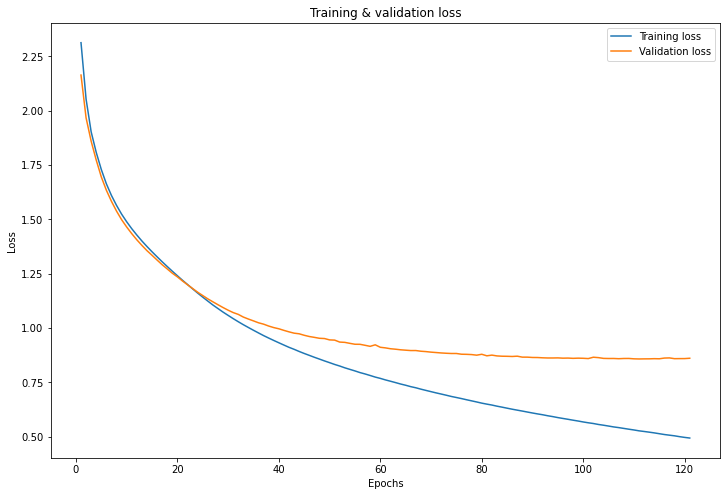

In [44]:
model_2_dict = model_2_val.history
# Plot the loss vs the number of epoch

fig, ax = plt.subplots(figsize=(12, 8))

loss_values = model_2_dict['loss']
val_loss_values = model_2_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
ax.plot(epochs, loss_values, label='Training loss')
ax.plot(epochs, val_loss_values, label='Validation loss')

ax.set_title('Training & validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

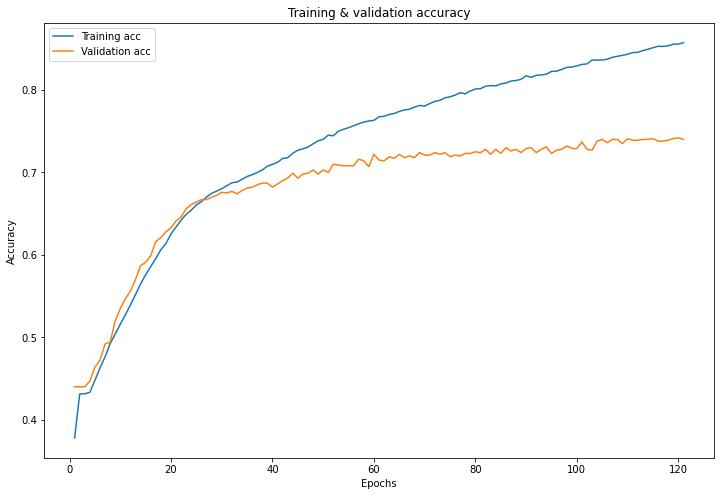

In [45]:
# Plot the training accuracy vs the number of epochs

fig, ax = plt.subplots(figsize=(12, 8))

acc_values = model_2_dict['acc'] 
val_acc_values = model_2_dict['val_acc']

ax.plot(epochs, acc_values, label='Training acc')
ax.plot(epochs, val_acc_values, label='Validation acc')
ax.set_title('Training & validation accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend();

* The graph shows better performance in terms of overfitting. I will now try `'Dropout Regularization'` to see if this will improve the results and accuracy.

## Model 3: Dropout Regularization

Dropout Regularization involves setting a certain proportion of units in each layer to zero. In the following cell I will:

* Apply a dropout rate of 30% to the input layer
* Add a first hidden layer with 50 units and 'relu' activation
* Apply a dropout rate of 30% to the first hidden layer
* Add a second hidden layer with 25 units and 'relu' activation
* Apply a dropout rate of 30% to the second hidden layer

In [46]:
random.seed(123)
dropout_model = models.Sequential()

# Implement dropout to the input layer
dropout_model.add(layers.Dropout(0.3, input_shape=(3000,)))

# Add the first hidden layer
dropout_model.add(layers.Dense(50, activation='relu'))

# Implement dropout to the first hidden layer 
dropout_model.add(layers.Dropout(0.3))

# Add the second hidden layer
dropout_model.add(layers.Dense(25, activation='relu'))

# Implement dropout to the second hidden layer 
dropout_model.add(layers.Dropout(0.3))

# Add the output layer
dropout_model.add(layers.Dense(12, activation='softmax'))


# Compile the model
dropout_model.compile(optimizer='SGD', 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])

# Train the model
dropout_model_val = dropout_model.fit(X_train_tokens, 
                                      y_train_lb, 
                                      epochs=150, 
                                      batch_size=256, 
                                      validation_data=(X_val_tokens, y_val_lb))

Epoch 1/150
30/30 [==============================] - 1s 9ms/step - loss: 2.4140 - acc: 0.1761 - val_loss: 2.2768 - val_acc: 0.4360
Epoch 2/150
30/30 [==============================] - 0s 5ms/step - loss: 2.2101 - acc: 0.3849 - val_loss: 2.0687 - val_acc: 0.4400
Epoch 3/150
30/30 [==============================] - 0s 6ms/step - loss: 2.0833 - acc: 0.4181 - val_loss: 1.9635 - val_acc: 0.4400
Epoch 4/150
30/30 [==============================] - 0s 5ms/step - loss: 2.0127 - acc: 0.4276 - val_loss: 1.8959 - val_acc: 0.4400
Epoch 5/150
30/30 [==============================] - 0s 5ms/step - loss: 1.9508 - acc: 0.4284 - val_loss: 1.8407 - val_acc: 0.4400
Epoch 6/150
30/30 [==============================] - 0s 5ms/step - loss: 1.8994 - acc: 0.4284 - val_loss: 1.7937 - val_acc: 0.4400
Epoch 7/150
30/30 [==============================] - 0s 5ms/step - loss: 1.8674 - acc: 0.4269 - val_loss: 1.7526 - val_acc: 0.4400
Epoch 8/150
30/30 [==============================] - 0s 5ms/step - loss: 1.8180 - a

30/30 [==============================] - 0s 5ms/step - loss: 1.2151 - acc: 0.6169 - val_loss: 1.0851 - val_acc: 0.6620
Epoch 64/150
30/30 [==============================] - 0s 5ms/step - loss: 1.2225 - acc: 0.6152 - val_loss: 1.0810 - val_acc: 0.6660
Epoch 65/150
30/30 [==============================] - 0s 5ms/step - loss: 1.2257 - acc: 0.6111 - val_loss: 1.0782 - val_acc: 0.6630
Epoch 66/150
30/30 [==============================] - 0s 5ms/step - loss: 1.2140 - acc: 0.6160 - val_loss: 1.0731 - val_acc: 0.6650
Epoch 67/150
30/30 [==============================] - 0s 5ms/step - loss: 1.2132 - acc: 0.6211 - val_loss: 1.0684 - val_acc: 0.6720
Epoch 68/150
30/30 [==============================] - 0s 5ms/step - loss: 1.2075 - acc: 0.6260 - val_loss: 1.0647 - val_acc: 0.6740
Epoch 69/150
30/30 [==============================] - 0s 5ms/step - loss: 1.2029 - acc: 0.6200 - val_loss: 1.0636 - val_acc: 0.6680
Epoch 70/150
30/30 [==============================] - 0s 6ms/step - loss: 1.1960 - acc: 0

Epoch 125/150
30/30 [==============================] - 0s 6ms/step - loss: 1.0108 - acc: 0.6832 - val_loss: 0.9352 - val_acc: 0.7150
Epoch 126/150
30/30 [==============================] - 0s 5ms/step - loss: 1.0130 - acc: 0.6779 - val_loss: 0.9333 - val_acc: 0.7150
Epoch 127/150
30/30 [==============================] - 0s 5ms/step - loss: 0.9972 - acc: 0.6825 - val_loss: 0.9313 - val_acc: 0.7180
Epoch 128/150
30/30 [==============================] - 0s 5ms/step - loss: 1.0020 - acc: 0.6839 - val_loss: 0.9327 - val_acc: 0.7180
Epoch 129/150
30/30 [==============================] - 0s 5ms/step - loss: 1.0020 - acc: 0.6825 - val_loss: 0.9294 - val_acc: 0.7170
Epoch 130/150
30/30 [==============================] - 0s 5ms/step - loss: 1.0030 - acc: 0.6841 - val_loss: 0.9290 - val_acc: 0.7200
Epoch 131/150
30/30 [==============================] - 0s 6ms/step - loss: 1.0054 - acc: 0.6868 - val_loss: 0.9259 - val_acc: 0.7230
Epoch 132/150
30/30 [==============================] - 0s 6ms/step - 

In [47]:
results_train = dropout_model.evaluate(X_train_tokens, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = dropout_model.evaluate(X_test_tokens, y_test_lb)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')   

235/235 [==============================] - 0s 740us/step - loss: 0.7207 - acc: 0.7852
Training Loss: 0.721 
Training Accuracy: 0.785
----------
47/47 [==============================] - 0s 918us/step - loss: 0.8685 - acc: 0.7227
Test Loss: 0.869 
Test Accuracy: 0.723


## Plot the Results

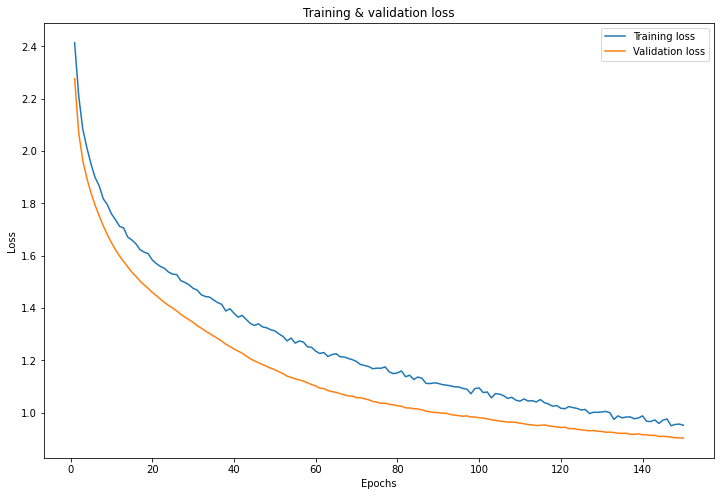

In [48]:
model_drop_dict = dropout_model_val.history

# Plot the loss vs the number of epoch

fig, ax = plt.subplots(figsize=(12, 8))

loss_values = model_drop_dict['loss']
val_loss_values = model_drop_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
ax.plot(epochs, loss_values, label='Training loss')
ax.plot(epochs, val_loss_values, label='Validation loss')

ax.set_title('Training & validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

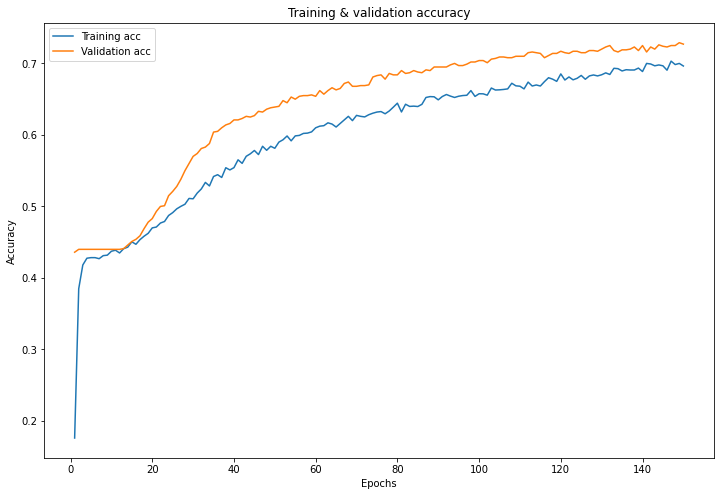

In [49]:
# Plot the training accuracy vs the number of epochs

fig, ax = plt.subplots(figsize=(12, 8))

acc_values = model_drop_dict['acc'] 
val_acc_values = model_drop_dict['val_acc']

ax.plot(epochs, acc_values, label='Training acc')
ax.plot(epochs, val_acc_values, label='Validation acc')
ax.set_title('Training & validation accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend();

Although the accuracy score went down, I was able to eliminate the overfitting of the model to the training set. 

## Make predictions

I will output (probability) predictions for the test set.

In [50]:
y_pred = dropout_model.predict(X_test_tokens)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test_lb, axis=1)

labels = lb.classes_

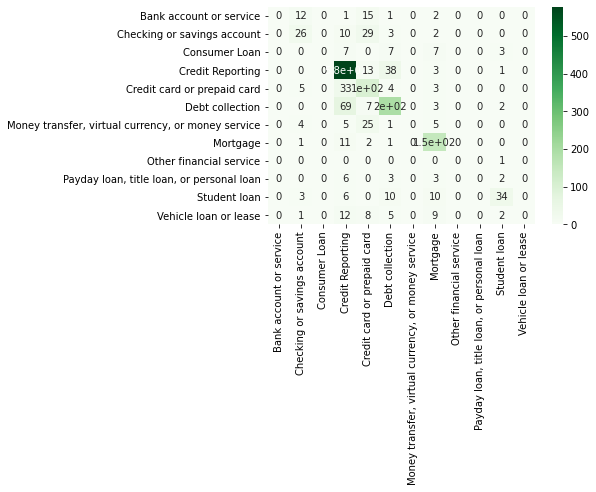

In [51]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, cmap='Greens', annot=True, xticklabels=labels,
           yticklabels=labels)

* It is difficult to read the confusion matrix with 12 categories, but it is clear that diagonal values that correspond to true values are high enough.

## Modeling Conclusions

1. With dropout regularization I was able to achieve more sufficient results for model. The accuracy of the model is 0.79 for the final model on training set.

2. The data is imbalanced, since most of the complaints fall into `Credit Reporting` category. 


# Conclusions

1. Most of the complaints are about credit reporting and it would be suggested to closely investigate the credit deparment of the banks.

2. Since the complaints are mostly related to incorrect information, it would be benefitial to improve the ability of proper data handling

3. The companies such as Equifax and Transunion should closesly investigate their credit report department.

# Next Steps

1. Deal with data imbalance

2. Bin the `Product` feature to less categories.